*https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html*

# Common pitfalls in interpretation of coefficients of linear models

In linear models, the target value is modeled as a linear combination of the features. Coefficients in multiple linear models represent the relationship between given features $X_i$ and the target $y_i$, assuming that all the other features remain constant.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## The dataset: wages

In [3]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

In [4]:
X = survey.data[survey.feature_names]
X.describe(include='all')

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Note that the dataset contains categorical and numerical variables.

In [5]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


Our target for prediction: the wage. Wages are described as floating-point number in dollars per hour.

In [6]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

We split the samples into a train and a test dataset. Only the train dataset will be used in the following exploratory ananlysis.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, let's get some insights by looking at the variable distributions and the pariwise relationship between them. Only numerical variables will be used.

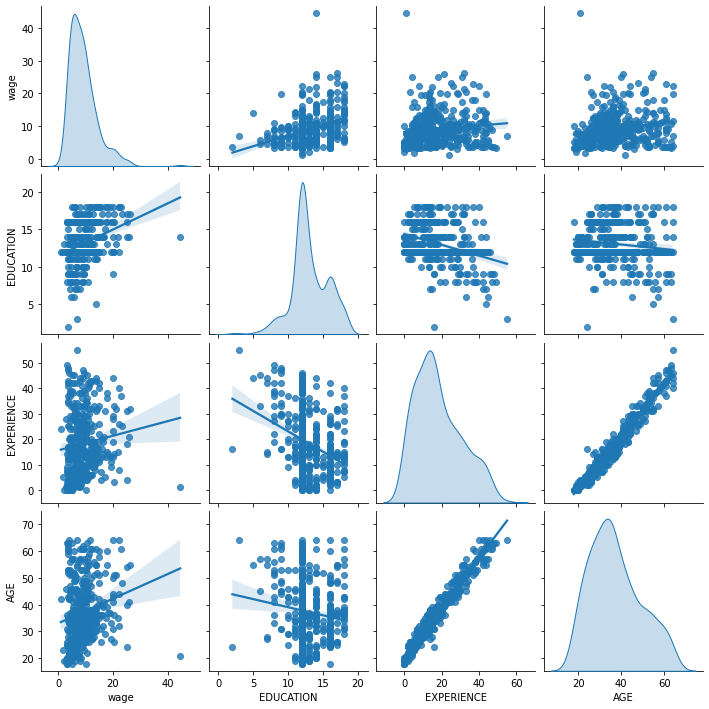

In [8]:
train_dataset = X_train.copy()
train_dataset.insert(0, 'wage', y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

**Looking closely at the wage distribution reveals that  it has a long tail. For this reason, we should take its logarithm to turn it approximately into a normal distribution. (Linear model such as ridge or lasso work best for a normal distribution of error.**

**The WAGE is increasing when EDUCATION is increasing. Note that the dependence between WAGE and EDUCATION represented here is a marginal dependence, i.e., it describes the behavior of a specific vairable without keeping the others fixed.**

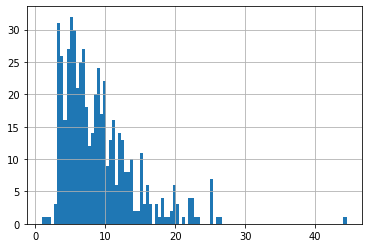

In [9]:
pd.Series(y).hist(bins=100)

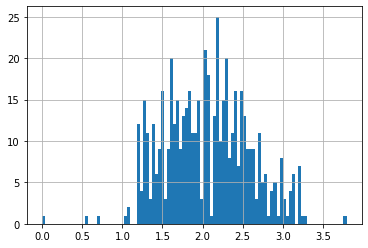

In [10]:
pd.Series(np.log(y)).hist(bins=100)

## The machine-learning pipeline

In [11]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   AGE         534 non-null    float64 
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), float64(3)
memory usage: 17.1 KB


The dataset contains columns with different data types and we need to apply to a specific precessing for each data types. In particular categorical variables cannot be included in linear model if not coded as integers first. In addition, to avoid categorical features to be treated as ordered values, we need to one-hot-encode them.

* one-hot encode the categorical columns
* as a first approach, keep numerical values as they are

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR',
                       'MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    remainder='passthrough')

To describe the dataset as a linear model we use a ridge regressor with a very small regularization and to model the algorithm of the WAGE.

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(preprocessor,
                     TransformedTargetRegressor(regressor=Ridge(alpha=1e-10),
                                               func=np.log10,
                                               inverse_func=sp.special.exp10))

## Processing the dataset

Fit the model.

In [14]:
_ = model.fit(X_train, y_train)

Check the performance of the computed model plotting its predictions on the test  set and computing, for example, the median absoluate error of the model.

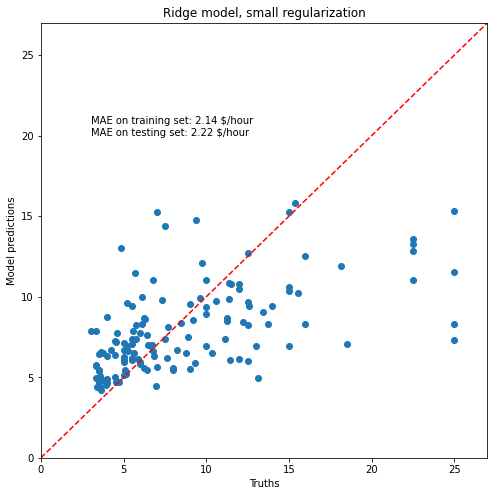

In [15]:
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'

y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'

fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', c='red')

plt.text(3, 20, string_score)
plt.title('Ridge model, small regularization')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

The model learnt is far from being a good model making accurate preditions: this is obvious when looking at the plot above, where good predictions should lie on the red line.

In the following section, we will interpret the coefficients of the model. While we do so, we should keep in mind that any conculusion we draw is about the model that we build, rather than about the true generative process os the data.

## Interpreting coefficients: scale matters

In [16]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.concatenate(
    [feature_names, numerical_columns])
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs

,Coefficients
RACE_Hispanic,-0.013557
RACE_Other,-0.009113
RACE_White,0.022556
OCCUPATION_Clerical,0.000053
OCCUPATION_Management,0.090536
OCCUPATION_Other,-0.025093
OCCUPATION_Professional,0.071972
OCCUPATION_Sales,-0.046628
OCCUPATION_Service,-0.091045
SECTOR_Construction,-0.000177


This representation of the coefficients has the benefit of making clear the pratical preditions of the model:

* an increase of 1 year in AGE means a decrease of 0.030867
* an increase of 1 year in EDUCATION means an increase of 0.054699 dollars/hour

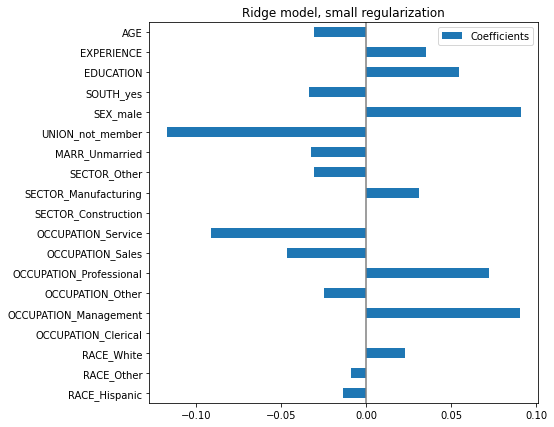

In [17]:
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

From the plot above the most important factor in determining WAGE appears to be the variable UNION, even if our intuition might tell us that variable like EXPERIENCE should be more impact.

Looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on small scale, while others, like AGE, varies a lot more, serveral decades.

This is visible if we compare the standard deviationgs of different features.

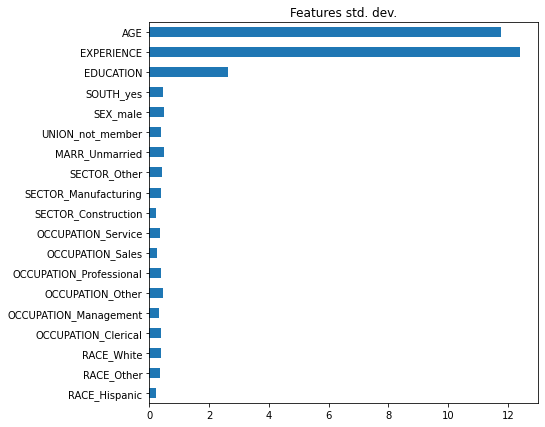

In [18]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)

X_train_preprocessed.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.')
plt.subplots_adjust(left=0.3)

Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the same unit of measure. As we will after this is equivalent to normalize numerical variables to their standard deviation(标准差), as $y = \sum coef_i *X_i = \sum (coef_i * std_i) * (\frac{X_i}{std_i})$

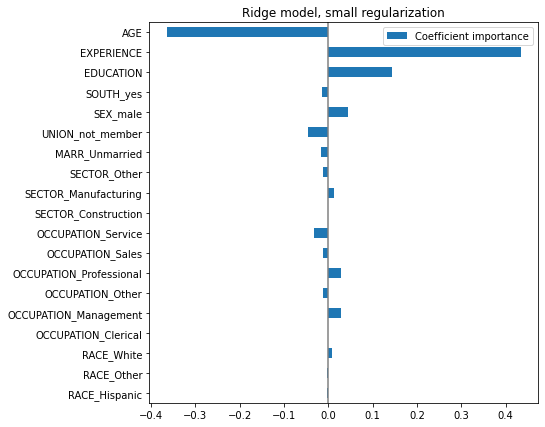

In [19]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Now that the coefficents have been scaled.

The plot above tell us about dependencies between a specific feature and the target when all other features remain constant, i.e., *conditional dependencies*. An increase of AGE will induce a decrease of the WAGE when all other features remain constant. On the contrary(相反), an increase of the EXPERIENCE will induce an increase of the WAGE when all other feature remain constant. Also, **AGE, EXPERIENCE and EDUCATION are the three variables that most influence the model.**

## Checking the variability of the coefficients

/Users/hotbaby/Library/Python/3.7/lib/python/site-packages/seaborn/categorical.py:1296: UserWarning: 76.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/hotbaby/Library/Python/3.7/lib/python/site-packages/seaborn/categorical.py:1296: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/hotbaby/Library/Python/3.7/lib/python/site-packages/seaborn/categorical.py:1296: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/hotbaby/Library/Python/3.7/lib/python/site-packages/seaborn/categorical.py:1296: UserWarning: 72.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/hotbaby/Library/Python/3.7/lib/py

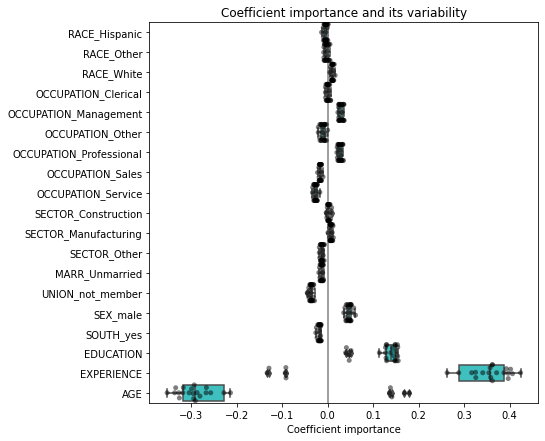

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

## The problem of correlated variables

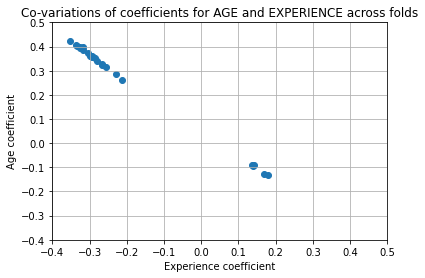

In [21]:
plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title('Co-variations of coefficients for AGE and EXPERIENCE '
              'across folds')

Two regions are populated: when the EXPERIENCE coefficient is postive the AGE one is negative and viceversa.

## Preprocessing numerical variables

The preprocessor is redefined in order to subtract the mean and scale variables to unit variance.

In [22]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

The model will stay unchanged.

In [23]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)

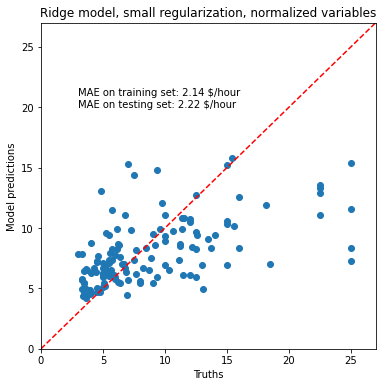

In [24]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title('Ridge model, small regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

For the coefficient analysis, scaling is not needed this time.

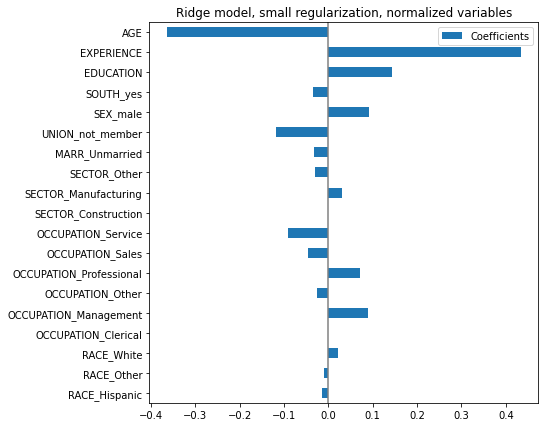

In [25]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Linear model with regularization

In machine-learning practice, Ridge Regressor is more often used with non-negligible regularization.

Above, we limited this regularization to a very little amount. Regularization improves the conditioning of the problem and reduces the variance of the estimates. RdigeCV applies corss validation in order to determine which value of the regularization parameter(alpha) is best suited for predition.

In [26]:
from sklearn.linear_model import RidgeCV

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

_ = model.fit(X_train, y_train)

First we check which value of $\alpha$ has been selected.

In [27]:
model[-1].regressor_.alpha_

10.0

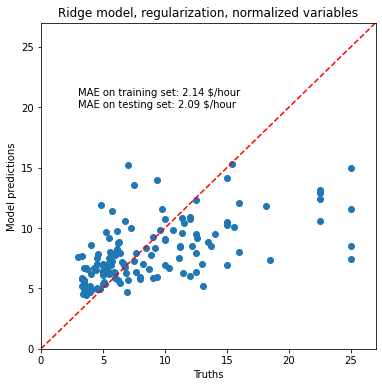

In [28]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f} $/hour'
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f} $/hour'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.text(3, 20, string_score)

plt.title('Ridge model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

The ability to reproduce the data of the regualized model is similar to the one of the non-reguarized model.

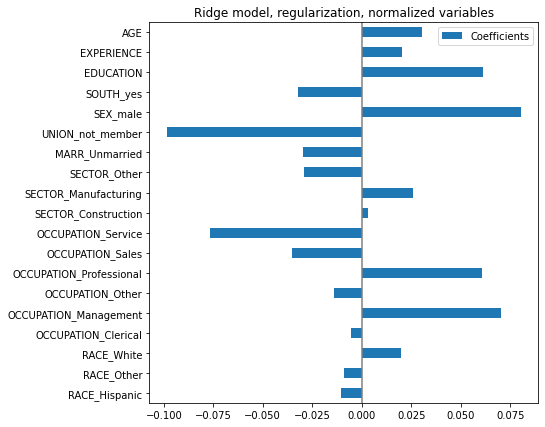

In [29]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, regularization, normalized variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

**The coefficients are significantly different. AGE and EXPERIENCE coefficients are both positive but they now have less influence to the prediction.**

**The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

On the other hand, the weights obtained with regularization are more stable. This increased stability is visible from the plot, obtained from data pertuabations, in a cross validation.

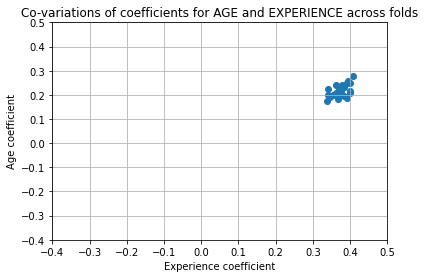

In [30]:
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)

plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs['AGE'], coefs['EXPERIENCE'])
_ = plt.title('Co-variations of coefficients for AGE and EXPERIENCE across folds')

## Lessons learned

* Coefficients must be scaled to the same unit of measure to retrieve feature importance. Scaling them with the standard-deviation of the feature is a useful proxy.
* Coefficients in multivariate linear model represent the dependency between a given feature and the target, **conditional** on the other features.
* Correlated features induce instabilities in the coefficients of linear models and their effects cannot be well teased apart.
* Different linear models respond differently to feature correlation and coefficients could significantly vary from one another.
* Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.